In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

# 1. Logreg with SGD

In [13]:
class LogisticRegression:
    def __init__(self, batch_size, eta, max_iter):
        self.batch_size = batch_size
        self.w = np.ndarray((1,))
        self.max_iter = max_iter
        self.eta = eta
        self.__train_result = None
            
    def train(self, X, y, test_size=0.3):
        self.w = np.ones((X.shape[1], 1), dtype=float)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True,
                                                           stratify=y[:, 0])
        prev_loss = self.__loss(X_test, y_test)
        error = 1
        it = 0
        
        self.__train_result = {'n_iters': 0,
                               'loss': [],
                               'accuracy': [],
                               'roc_auc': []}
        
        while self.__train_result['n_iters'] < self.max_iter:
            w_old = self.w.copy()
            indexes = np.random.permutation(X_train.shape[0])
            for batch_start in range(0, X_train.shape[0], self.batch_size):
                idx = [indexes[i] for i in range(batch_start, min(batch_start + self.batch_size,
                                                               X_train.shape[0]))]                
                g = (-1 / self.batch_size) * X_train[idx, :].T @ (y_train[idx] 
                                                          / (1 + np.exp(y_train[idx] * X_train[idx] @ self.w)))
                self.w -= self.eta * g
                
            loss = self.__loss(X_test, y_test)
            acc = accuracy_score(y_test, self.predict(X_test))
            self.__train_result['loss'].append(loss)
            self.__train_result['accuracy'].append(acc)
            self.__train_result['n_iters'] += 1
            self.__train_result['roc_auc'].append(roc_auc_score(y_test, self.predict_proba(X_test)))
            
            if loss > prev_loss:
                self.w = w_old
                break
            prev_loss = loss
        
    def predict(self, X):
        fx = 1 / (1 + np.exp(-X @ self.w))
        return [1 if x > 0.5 else -1 for x in fx[:, 0]]
    
    def predict_proba(self, X):
        return 1 / (1 + np.exp(-X @ self.w))
    
    def get_train_result(self):
        return self.__train_result
    
    def __loss(self, X, y):
        return np.mean(np.log(1 + np.exp(- y * X @ self.w)))

In [3]:
def transform_dataset(ds):
    y = [-1 if x == 0 else 1 for x in pd.factorize(ds.label.values)[0]]
    y = np.asarray(y).reshape((-1, 1))
    X = StandardScaler().fit_transform(ds.drop(columns=['label']).values)
    X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    
    return X, y

In [4]:
def plot_lr_result(lr, ds_name):
    res = lr.get_train_result()
    
    print(f"Dataset: {ds_name}")
    print(f"SGD params: batch_size {lr.batch_size}; learning rate {lr.eta}")
    print(f"Stopped at {res['n_iters']}th iteration")
    print(f"Best loss: {res['loss'][res['n_iters'] - 2]}")
    
    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.plot([ x + 1 for x in range(res['n_iters'])],res['loss'])
    plt.title(f"Loss (test dataset)")
    plt.ylabel('loss function')
    plt.xlabel('iteration')
    
    plt.subplot(212)
    plt.plot([ x + 1 for x in range(res['n_iters'])],res['accuracy'])
    plt.title(f"Accuracy (test dataset)")
    plt.ylabel('accuracy')
    plt.xlabel('iteration')
    

In [5]:
spam = pd.read_csv('spam.csv')
spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [6]:
spam_X, spam_y = transform_dataset(spam)

In [14]:
spam_lr = LogisticRegression(batch_size=100, eta=0.1, max_iter=1000)

In [15]:
spam_lr.train(spam_X, spam_y, test_size=0.4)

Dataset: spam
SGD params: batch_size 100; learning rate 0.1
Stopped at 67th iteration
Best loss: 0.2373617230155711


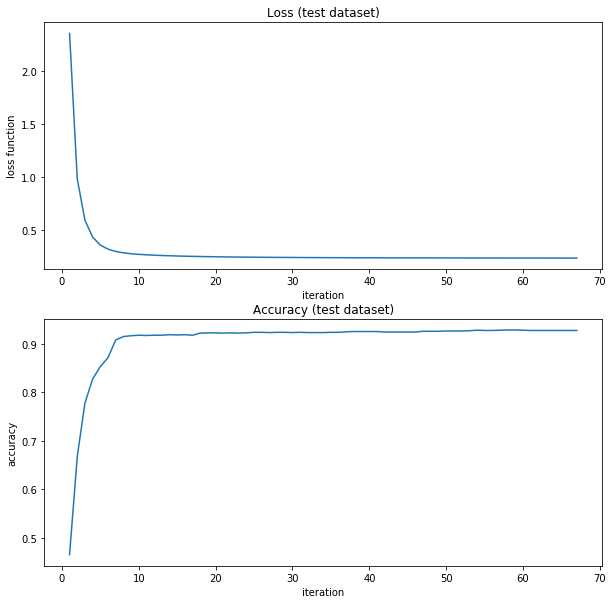

In [16]:
plot_lr_result(spam_lr, 'spam')

In [19]:
# специальные плохие параметры чтобы получить преждевременную остановку
spam_lr_bad = LogisticRegression(batch_size=10, eta=10, max_iter=500)
spam_lr_bad.train(spam_X, spam_y, test_size = 0.3)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encounter

Dataset: spam
SGD params: batch_size 10; learning rate 10
Stopped at 4th iteration
Best loss: 1.743769853362066


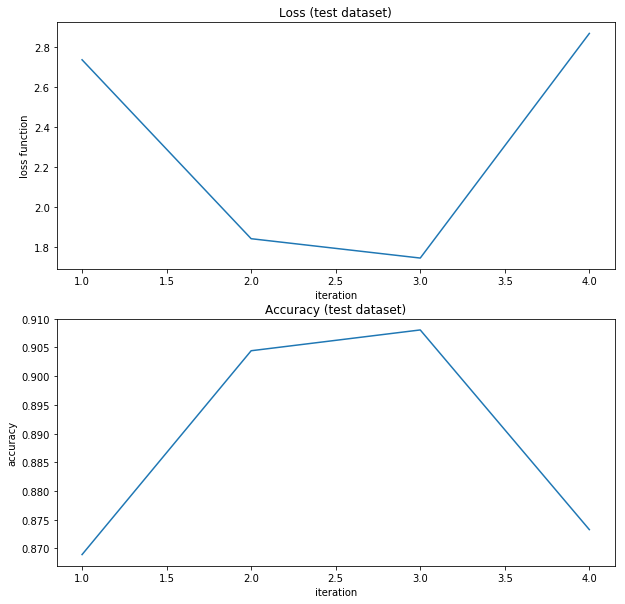

In [20]:
plot_lr_result(spam_lr_bad, 'spam')

In [21]:
cancer = pd.read_csv('cancer.csv')
cancer.head()

,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [22]:
cancer_X, cancer_y = transform_dataset(cancer)

In [26]:
cancer_lr = LogisticRegression(batch_size=20, eta=0.1, max_iter=500)

In [27]:
cancer_lr.train(cancer_X, cancer_y, test_size=0.3)

Dataset: cancer
SGD params: batch_size 20; learning rate 0.1
Stopped at 98th iteration
Best loss: 0.06940498847636126


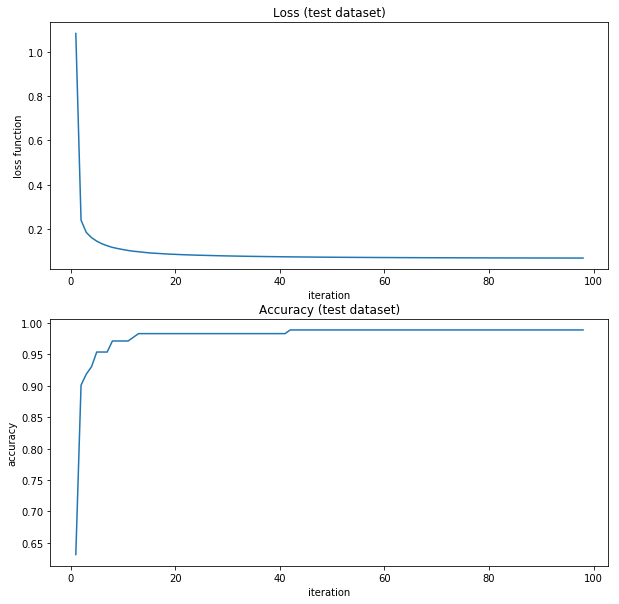

In [28]:
plot_lr_result(cancer_lr, 'cancer')